# **I. Data**

In [1]:
data_path = "/Linux/Odor/"

In [2]:
import pandas as pd
import numpy as np

### 원 데이터
odor = pd.read_csv(data_path + "New_data.csv", encoding="euc-kr")
odor = odor.drop(["yy", "mm", "dd", "farm"], axis = 1)    # 불필요한 변수 제거
odor.rename(columns = {"mm.1" : "mm"}, inplace = True)    # 추후 변수명을 편하게 사용하기 위해
print(odor.shape)
display(odor.head())

(57, 16)


,ou,nh3,h2s,mm,dms,dmds,aca,ppa,iba,bta,iva,vla,ph,pc,id,sk
0,300.0,0.56,145.0,0.09,12.80,0.025,30.60,17.57,2.78,10.80,3.64,7.72,2.84,0.03,0.20,3.00
1,300.0,0.62,310.0,19.40,462.00,0.025,916.52,1055.96,109.07,977.44,319.49,619.49,30.51,137.81,3.60,10.40
2,448.0,0.97,90.5,0.04,63.90,0.025,663.42,737.23,73.94,837.83,215.64,469.79,14.61,67.52,0.94,3.92
3,2080.0,1.02,344.0,0.04,13.00,0.630,490.79,570.61,51.09,719.27,168.48,237.64,8.90,60.56,5.55,7.31
4,310.0,1.18,312.0,0.04,0.04,0.025,404.53,468.03,43.17,573.75,157.22,205.67,9.21,69.90,0.20,5.43


## **1. Train and Test dataset**

In [3]:
def train_test_data(data, test_size, shuffle, random_state):
  from sklearn.model_selection import train_test_split
  import pandas as pd

  X = data.iloc[:, 1:]
  y = data.loc[:, "ou"]

  train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = test_size, 
                                                      shuffle = shuffle, random_state = random_state)
  train_X = train_X.reset_index(drop=True)
  test_X = pd.DataFrame(test_X).reset_index(drop=True)
  train_y = train_y.reset_index(drop=True)
  test_y = test_y.reset_index(drop=True)

  return {"train X" : train_X, "test X" : test_X, "train y" : train_y, "test y" : test_y}

## **2. StandardScaler**

In [4]:
def prepro(train_X, test_X, train_y, log_y, log_X) :
  from sklearn.preprocessing import StandardScaler
  import numpy as np

  if log_X == "yes" :
    train_X = np.log(train_X)
    test_X = np.log(test_X)
    std_scale = StandardScaler().fit(train_X)

    st_train_X = pd.DataFrame(std_scale.transform(train_X), columns = train_X.columns)
    st_test_X = pd.DataFrame(std_scale.transform(test_X), columns = test_X.columns)

  else :
    std_scale = StandardScaler().fit(train_X)

    st_train_X = pd.DataFrame(std_scale.transform(train_X), columns = train_X.columns)
    st_test_X = pd.DataFrame(std_scale.transform(test_X), columns = test_X.columns)

  train_y = train_y
  if log_y == "yes" : 
    train_y = np.log(train_y)

  return {"st train X" : st_train_X, "st test X" : st_test_X, "train y" : train_y}

# **II. 변수 추출법**

In [5]:
def VE_reg(train_X, train_y, test_X, random_state) : 

  import statsmodels.api as sm
  from tqdm.notebook import tqdm
  from sklearn.preprocessing import StandardScaler
  from sklearn import model_selection
  from sklearn.model_selection import RepeatedKFold
  from sklearn.metrics import mean_squared_error
  from sklearn.cross_decomposition import PLSRegression
  from sklearn.decomposition import PCA
  from itertools import accumulate

  #"""< Multiple Regression >""""
  const_train_X = sm.add_constant(train_X, has_constant = "add")
  mr = sm.OLS(train_y, const_train_X).fit()

  const_test_X = sm.add_constant(test_X, has_constant = "add")
  mr_pred = pd.DataFrame(mr.predict(const_test_X), columns = ["predict"])


  #"""< PLS >"""
  st_train_y = (train_y - train_y.mean()) / train_y.std()
  std = StandardScaler().fit(train_X)
  st_train_X = std.transform(train_X)
  st_test_X = std.transform(test_X)
  
  cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = random_state)
  mse = []
  for i in tqdm(np.arange(1, train_X.shape[1]+1)) :
      pls = PLSRegression(n_components = i)
      score = -1*model_selection.cross_val_score(pls, st_train_X, st_train_y, cv = cv,
                                                scoring = 'neg_mean_squared_error').mean()
      mse.append(score)

  pls_bc = mse.index(min(mse)) + 1     # Best Component

  pls = PLSRegression(n_components = pls_bc)
  pls_fit = pls.fit(st_train_X, st_train_y)
  pls_X = pd.DataFrame(pls_fit.transform(st_train_X), columns = ["comp " + str(i+1) for i in range(pls_bc)])
  pls_test_X = pd.DataFrame(pls_fit.transform(st_test_X), columns = ["comp " + str(i+1) for i in range(pls_bc)])

  const_pls_X = sm.add_constant(pls_X, has_constant = "add")
  pls_mr = sm.OLS(train_y, const_pls_X).fit()

  const_pls_test_X = sm.add_constant(pls_test_X, has_constant = "add")
  pls_mr_pred = pd.DataFrame(pls_mr.predict(const_pls_test_X), columns = ["predict"])


  #"""< PCA >"""
  pca = PCA(n_components = train_X.shape[1], random_state = 0).fit(st_train_X)
  cum_var = list(accumulate(pca.explained_variance_ratio_)) 
  pca_idx = np.where(np.array(cum_var) > 0.99)[0][0] + 1

  pca = PCA(n_components = pca_idx, random_state = 0).fit(st_train_X)
  pca_X = pca.transform(st_train_X)
  pca_X = pd.DataFrame(pca_X, columns = ["comp" + str(i) for i in range(pca_X.shape[1])])

  pca_test_X = pca.transform(st_test_X)
  pca_test_X = pd.DataFrame(pca_test_X, columns = ["comp" + str(i) for i in range(pca_test_X.shape[1])])

  const_pca_X = sm.add_constant(pca_X, has_constant = "add")
  pca_mr = sm.OLS(train_y, const_pca_X).fit()

  const_pca_test_X = sm.add_constant(pca_test_X, has_constant = "add")
  pca_mr_pred = pd.DataFrame(pca_mr.predict(const_pca_test_X), columns = ["predict"])

  return {"mr pred" : mr_pred, "pls mr pred" : pls_mr_pred, "pca mr pred" : pca_mr_pred,
          "pls bc" : pls_bc, "pca bc" : pca_idx}

# **III. 변수 선택법**

In [6]:
def VS_reg(train_X, train_y, test_X, random_state) : 

  import statsmodels.api as sm
  from sklearn.linear_model import RidgeCV
  from sklearn.linear_model import LassoCV
  from sklearn.linear_model import ElasticNetCV

  ### Ridge
  rdg = RidgeCV(alphas = [i*0.01 for i in range(1, 100)]).fit(train_X, train_y)
  rdg_pred = pd.DataFrame(rdg.predict(test_X), columns = ["predict"])


  ### Lasso
  las = LassoCV(alphas = [i*0.01 for i in range(1, 100)], random_state = random_state).fit(train_X, train_y)
  las_pred = pd.DataFrame(las.predict(test_X), columns = ["predict"])

  
  ### Elastic Net
  elas = ElasticNetCV(l1_ratio = [i*0.01 for i in range(1, 100)], alphas = [i*0.01 for i in range(1, 100)],
                      random_state = 99).fit(train_X, train_y)
  elas_pred = pd.DataFrame(elas.predict(test_X), columns = ["predict"])

  return {"ridge pred" : rdg_pred, "lasso pred" : las_pred, "elasticnet pred" : elas_pred}

# **IV. Machine Learning**

In [7]:
!pip install optuna

In [8]:
def ML_hpo(train_X, train_y, test_X, verbose, random_state) :

  from sklearn.ensemble import RandomForestRegressor
  from sklearn.ensemble import ExtraTreesRegressor
  from xgboost import XGBRFRegressor
  import optuna
  from optuna import Trial, visualization
  from optuna.samplers import TPESampler              # TPESampler : TPE
  from optuna.integration import SkoptSampler         # SkoptSampler : Gaussian Process
  from sklearn.model_selection import cross_val_score
  from functools import partial


  # """< Random Forest >"""
  def optimize_rf(trial, X, y) :
    param = {"n_estimators" : trial.suggest_int("n_estimators", 2900, 3000),
            "max_depth" : trial.suggest_int("max_depth", 5, 15),
            "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 5),
            "min_samples_split" : trial.suggest_int("min_samples_split", 2, 6)
            } 

    model = RandomForestRegressor(**param)  
    rf_score = cross_val_score(model, X, y, cv = 10, scoring = "neg_mean_squared_error", verbose = verbose).mean()
  
    return  rf_score

  # """< Extremely Tree >"""
  def optimize_et(trial, X, y) :
    param = {"n_estimators" : trial.suggest_int("n_estimators", 2900, 3000),
            "max_depth" : trial.suggest_int("max_depth", 5, 15),
            "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 5),
            "min_samples_split" : trial.suggest_int("min_samples_split", 2, 6)
            } 

    model = ExtraTreesRegressor(**param)
    et_score = cross_val_score(model, X, y, cv = 10, scoring = "neg_mean_squared_error", verbose = verbose).mean()
    
    return  et_score

  # """< XGB >"""
#   def optimize_xg(trial, X, y) :
#     param = {'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
#               'lambda': trial.suggest_loguniform('lambda', 1e-1, 3.0),
#               'alpha': trial.suggest_loguniform('alpha', 1e-1, 3.0),
            
#               'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
#               "n_estimators" : trial.suggest_int("n_estimators", 2900, 3000),
#               'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
            
#               'min_child_weight': trial.suggest_int('min_child_weight', 10, 300)
#               }
#     model = XGBRFRegressor(**param)                   
#     xg_score = cross_val_score(model, X, y, cv = 10, scoring = "neg_mean_squared_error", verbose = verbose).mean()
#     return  xg_score


  ### Defining optimization_function as partial and calling optimize within it
  rf_optimization_function = partial(optimize_rf, X = train_X, y = train_y)
  et_optimization_function = partial(optimize_et, X = train_X, y = train_y)
#   xg_optimization_function = partial(optimize_xg, X = train_X, y = train_y)
  study = optuna.create_study(direction = "maximize", sampler = TPESampler())

  ### Printing the best hyperparemeter set
  study.optimize(rf_optimization_function, n_trials = 5)
  rf_best_params = study.best_trial.params

  study.optimize(et_optimization_function, n_trials = 5)
  et_best_params = study.best_trial.params

#   study.optimize(xg_optimization_function, n_trials = 5)
#   xg_best_params = study.best_trial.params


  rf = RandomForestRegressor(**rf_best_params, random_state = random_state).fit(train_X, train_y)
  rf_pred = pd.DataFrame(rf.predict(test_X), columns = ["predict"])

  et = ExtraTreesRegressor(**et_best_params, random_state = random_state).fit(train_X, train_y)
  et_pred = pd.DataFrame(et.predict(test_X), columns = ["predict"])

#   xg = XGBRFRegressor(**xg_best_params, random_state = random_state).fit(train_X, train_y)
  xg = XGBRFRegressor(random_state = random_state).fit(train_X, train_y)
  xg_pred = pd.DataFrame(xg.predict(test_X), columns = ["predict"])

  return {"rf pred" : rf_pred, "et pred" : et_pred, "xg pred" : xg_pred,
          "rf best params" : rf_best_params, "et best params" : et_best_params}#, "xg best params" : xg_best_params}

# **V. Neural Network**

In [9]:
def NN_hpo(train_X, train_y, test_X, epo, log_y, random_state) :
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense
  import tensorflow as tf
  from sklearn.neural_network import MLPRegressor
  from sklearn.model_selection import GridSearchCV

  # """< ANN >"""
  tf.random.set_seed(random_state)
  
  model = Sequential()
  model.add(Dense(10, input_dim = train_X.shape[1], activation = "relu"))
  model.add(Dense(1))
  model.compile(loss = "mean_squared_error",            # 손실함수
                optimizer = "adam",                     # 옵티마이저 설정
                metrics = ["mean_squared_error"])       # 모형 평가 지표

  model.fit(train_X, train_y, epochs = epo, verbose = 0)
  ann_pred = pd.DataFrame(model.predict(test_X), columns = ["predict"])
  

  mlp1_pred = []  ; mlp2_pred = []
  mlp1_best_params = [] ; mlp2_best_params = []

  if log_y == "no" : 
    # """< MLP 1 layer >"""
    mlp1 = MLPRegressor()
    mlp1_gs = GridSearchCV(mlp1, param_grid={'hidden_layer_sizes': [i for i in range(5,10)],
                                            'activation': ['relu'],
                                            'solver': ['adam'],
                                            'learning_rate': ['constant'],
                                            'learning_rate_init': [0.001],
                                            'power_t': [0.5],
                                            'alpha': [0.0001],
                                            'max_iter': [10000],
                                            'early_stopping': [False],
                                            'warm_start': [False]})
    mlp1_gs.fit(train_X, train_y)
    mlp1_best_params = mlp1_gs.best_params_

    mlp1 = MLPRegressor(**mlp1_best_params, random_state = random_state).fit(train_X, train_y)
#     mlp1 = MLPRegressor(random_state = random_state).fit(train_X, train_y)
    mlp1_pred = pd.DataFrame(mlp1.predict(test_X), columns = ["predict"])

    # """< MLP 2 layers >"""
    mlp2 = MLPRegressor()
    mlp2_gs = GridSearchCV(mlp2, param_grid={'hidden_layer_sizes': [(i,j) for i in range(3,7) for j in range(3,7)],
                                            'activation': ['relu'],
                                            'solver': ['adam'],
                                            'learning_rate': ['constant'],
                                            'learning_rate_init': [0.001],                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
                                            'power_t': [0.5],
                                            'alpha': [0.0001],
                                            'max_iter': [10000],
                                            'early_stopping': [False],
                                            'warm_start': [False]}) 

    mlp2_gs.fit(train_X, train_y)
    mlp2_best_params = mlp2_gs.best_params_
    mlp2 = MLPRegressor(**mlp2_best_params, random_state = random_state).fit(train_X, train_y)
#     mlp2 = MLPRegressor(random_state = random_state).fit(train_X, train_y)
    mlp2_pred = pd.DataFrame(mlp2.predict(test_X), columns = ["predict"])

  return {"ann pred" : ann_pred, "mlp1 pred" : mlp1_pred, "mlp2 pred" : mlp2_pred,
          "mlp1 best params" : mlp1_best_params, "mlp2 best params" : mlp2_best_params}

# **VI. Result Plot**

In [15]:
def Plot_odor(test_y, pred_list, log_y) :

  import statsmodels.api as sm
  import matplotlib.pyplot as plt
  from sklearn.metrics import r2_score


  def R2(true, pred) :
    import numpy as np
    sse = ((np.array(true) - np.array(pred))**2).sum()
    ssr = ((np.array(pred) - np.mean(true))**2).sum()
    sst = ((np.array(true) - np.mean(true))**2).sum()
    # r2 = 1 - (sse/sst)
    r2 = ssr/sst
    return np.round(r2, 3)

  def MAPE(true, pred) :
    import numpy as np
    mape = np.mean(np.abs((np.array(true) - np.array(pred)) / np.array(true))) * 100
    return np.round(mape, 3)

  def RMSE(true, pred) :
    import numpy as np
    mse = np.mean((np.array(true) - np.array(pred))**2)
    rmse = np.sqrt(mse)
    return np.round(rmse, 3)

  if log_y == "yes" :
    names = ["Multiple regression", "PLS regression", "PCA regression",
             "Ridge regression", "Lasso regression", "Elastic Net regression",
             "Random Forest", "Extremely Tree", "XGboost", 
             "ANN_sequential"]
    
    pred_list = [np.exp(pred_list[i]) for i in range(len(pred_list))]

  else :
    names = [#"Multiple regression", "PLS regression", "PCA regression",
             #"Ridge regression", "Lasso regression", "Elastic Net regression",
             #"Random Forest", "Extremely Tree", "XGboost", 
             "ANN_sequential", "MLP 1 layer", "MLP 2 layer"]

    pred_list = pred_list

  

  plt.figure(figsize = (21, 28))
  for i in range(len(pred_list)) :
    const_pred_list = sm.add_constant(pred_list[i], has_constant = "add")
    pred_ols = sm.OLS(test_y, const_pred_list).fit()
    linear_x = range(0, 8000, 1000)
    linear_y = pred_ols.params[0] + pred_ols.params[1]*linear_x

    plt.subplot(4, 3, i+1)
    plt.scatter(test_y, pred_list[i])
    plt.plot(linear_x, linear_y, color = "darkred")
    plt.xlim(-2000, 7000) ; plt.ylim(-2000, 7000)
    plt.plot([0, 7000], [0, 7000], color = "black")
    plt.axhline(0, color = "grey", linestyle = "--")
    plt.axvline(0, color = "grey", linestyle = "--")
    plt.xlabel("Observed", fontsize = 15)  ; plt.ylabel("predict", fontsize = 15)
    plt.text(-1700,6500, names[i], 
            fontsize = 15, weight = "bold",
            bbox = dict(facecolor = 'ivory', edgecolor = 'black', boxstyle = 'round'))
    plt.text(-1700, 4500, 
            "y = " + str(np.round(pred_ols.params[0], 3)) + "+" + str(np.round(pred_ols.params[1], 3)) + "x" +
            "\nR2 (OLS) : " + str(np.round(pred_ols.rsquared, 3)) +
            "\nR2 (SSR/SST) : " + str(R2(test_y, pred_list[i])) +
            "\nRMSE : " + str(RMSE(test_y, pred_list[i])) +
            "\nMAPE : " + str(MAPE(test_y, pred_list[i])),
            fontsize = 15,
            bbox = dict(facecolor = 'white', edgecolor = 'none', boxstyle = 'round'))
    
  plt.tight_layout()
  plt.show()

# **Total**

In [11]:
def Analysis_odor(data, test_size, shuffle, verbose, random_state,
                  preprocess, log_y, log_X, epo) :

  tt_split = train_test_data(data = data, test_size = test_size, shuffle = shuffle, random_state = random_state)
  train_X = tt_split["train X"]
  test_X = tt_split["test X"]
  train_y = tt_split["train y"]
  test_y = tt_split["test y"]

  if preprocess == "yes" :
    pre = prepro(train_X = train_X, test_X = test_X, train_y = train_y, log_y = log_y,log_X = log_X)
    train_X = pre["st train X"]
    test_X = pre["st test X"]
    train_y = pre["train y"]

#   ve = VE_reg(train_X = train_X, train_y = train_y, test_X = test_X, random_state = random_state)
#   mr_pred = ve["mr pred"]
#   pls_mr_pred = ve["pls mr pred"]
#   pca_mr_pred = ve["pca mr pred"]
#   pls_bc = ve["pls bc"] 
#   pca_bc = ve["pca bc"] 

#   vs = VS_reg(train_X = train_X, train_y = train_y, test_X = test_X, random_state = random_state)
#   rdg_pred = vs["ridge pred"]
#   las_pred = vs["lasso pred"]
#   elas_pred = vs["elasticnet pred"]

#   ml = ML_hpo(train_X = train_X, train_y = train_y, test_X = test_X, verbose = verbose, random_state = random_state)
#   rf_pred = ml["rf pred"]
#   et_pred = ml["et pred"]
#   xg_pred = ml["xg pred"]
#   rf_best_params = ml["rf best params"]
#   et_best_params = ml["et best params"]
#   xg_best_params = ml["xg best params"]

  nn = NN_hpo(train_X = train_X, train_y = train_y, test_X = test_X, log_y = log_y, epo = epo, random_state = random_state)
  ann_pred = nn["ann pred"]
  mlp1_pred = nn["mlp1 pred"]
  mlp2_pred = nn["mlp2 pred"]
  mlp1_best_params = nn["mlp1 best params"]
  mlp2_best_params = nn["mlp2 best params"]
  
  return {#"mr pred" : mr_pred, "pls mr pred" : pls_mr_pred, "pca mr pred" : pca_mr_pred,
          #"pls bc" : pls_bc, "pca bc" : pca_bc,
          #"ridge pred" : rdg_pred, "lasso pred" : las_pred, "elasticnet pred" : elas_pred,
          #"rf pred" : rf_pred, "et pred" : et_pred, "xg pred" : xg_pred,
          #"rf best params" : rf_best_params, "et best params" : et_best_params,# "xg best params" : xg_best_params,
          "ann pred" : ann_pred, "mlp1 pred" : mlp1_pred, "mlp2 pred" : mlp2_pred,
          "mlp1 best params" : mlp1_best_params, "mlp2 best params" : mlp2_best_params, "test y" : test_y}

In [12]:
from tqdm.notebook import tqdm

mr_pred = []  ; pls_mr_pred = []  ; pca_mr_pred = []
rdg_pred = [] ; las_pred = [] ; elas_pred = []
rf_pred = []  ; et_pred = []  ; xg_pred = []
ann_pred = [] ; mlp1_pred = []  ; mlp2_pred = []

for i in tqdm(range(odor.shape[0])) :
  new_odor1 = odor.drop(index = i)
  new_odor2 = pd.DataFrame(odor.iloc[i, :]).T
  new_odor = pd.concat([new_odor1, new_odor2], axis = 0)
  result = Analysis_odor(data = new_odor, test_size = 1/new_odor.shape[0], shuffle = False, 
                         verbose = 0, random_state = 99,
                         preprocess = "yes", log_y = "no",log_X = "no", epo = 100)
  
#   mr_pred.append(result["mr pred"].values[0][0])
#   pls_mr_pred.append(result["pls mr pred"].values[0][0])
#   pca_mr_pred.append(result["pca mr pred"].values[0][0])
#   rdg_pred.append(result["ridge pred"].values[0][0])
#   las_pred.append(result["lasso pred"].values[0][0])
#   elas_pred.append(result["elasticnet pred"].values[0][0])
#   rf_pred.append(result["rf pred"].values[0][0])
#   et_pred.append(result["et pred"].values[0][0])
#   xg_pred.append(result["xg pred"].values[0][0])
  ann_pred.append(result["ann pred"].values[0][0])
  mlp1_pred.append(result["mlp1 pred"].values[0][0])
  mlp2_pred.append(result["mlp2 pred"].values[0][0])

  0%|          | 0/57 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

In [16]:
pred_list = [#mr_pred, pls_mr_pred, pca_mr_pred,
             #rdg_pred, las_pred, elas_pred,
             #rf_pred, et_pred, xg_pred,
             ann_pred, mlp1_pred, mlp2_pred]

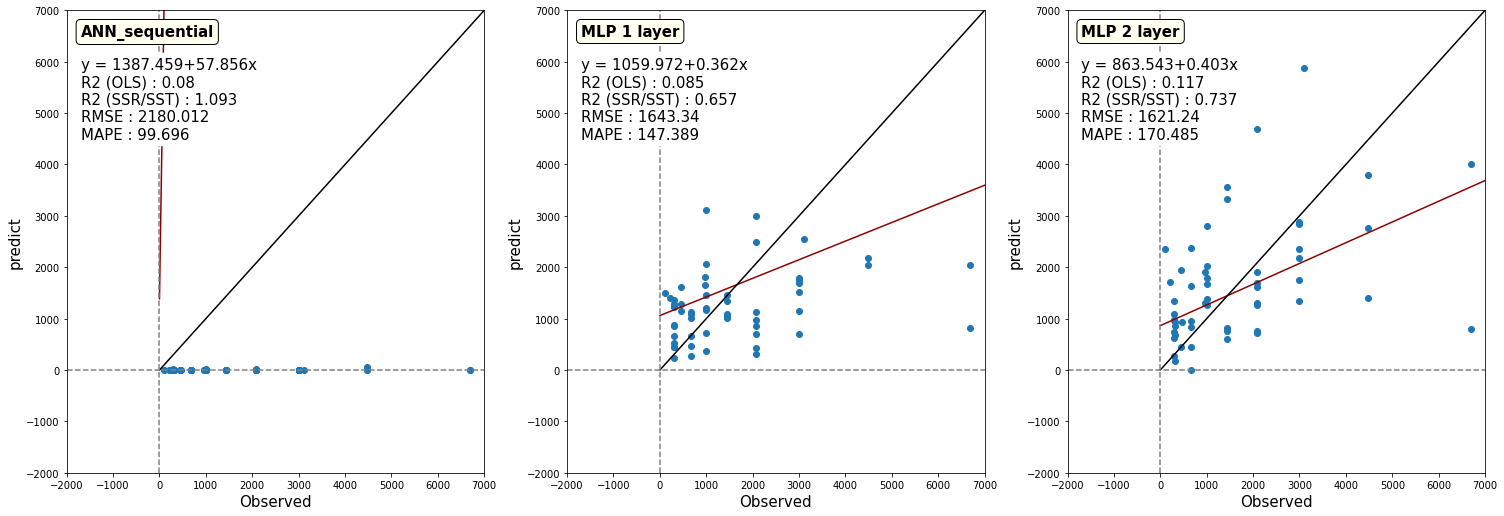

In [17]:
Plot_odor(test_y = odor.loc[:,"ou"], pred_list = pred_list, log_y = "no")